# Markov State Modelling

The goal of `ammo` is to use MSMs to determine whether a binder is an allosteric modulator and affects protein activity. This means the MSMs have to be compared, which in turn requires that they are built in a comparable way. The `MSMCollection` class contains `MSM` objects (based on [pyemma](http://emma-project.org/latest/) modelling) and goes through the process of building multiple models at the same time.

In [1]:
from ammo.msm import MSM, MSMCollection

<>:5: DeprecationWarning: invalid escape sequence \A
<>:5: DeprecationWarning: invalid escape sequence \A
<>:5: DeprecationWarning: invalid escape sequence \A
<>:5: DeprecationWarning: invalid escape sequence \A
/tmp/ipykernel_112591/4007344235.py:5: DeprecationWarning: invalid escape sequence \A
  features=['RMSD/$\AA$', 'distance/$\AA$'],
/tmp/ipykernel_112591/4007344235.py:5: DeprecationWarning: invalid escape sequence \A
  features=['RMSD/$\AA$', 'distance/$\AA$'],
/home/adele/Documents/allostery/ammo/msm/_msm.py:455: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/adele/anaconda3/envs/bss/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/adele/Documents/allostery/ammo/msm/_msm.py:455: UserWarn

## Load data

The entry point to use `MSMCollection` is loading already featurized trajectory data. We have two examples provided in `example_data/`, a reference and data with a ligand called FRJ. The data files are called `rmsd_backbone_toclosed.txt` and `ptr_cys_dist.txt`, containing WPD loop RMSD and PTyr(P)-Cys215(S) distance respectively. The trajectory timestep in this case was 10 ps.

In [2]:
reference = ['example_data/reference/closed', 'example_data/reference/open']
frj = ['example_data/frj/closed', 'example_data/frj/open']

In [3]:
collection = MSMCollection()
collection.load_data(titles=['reference', 'FRJ'],
                     locations=[reference, frj],
                     file_names=['rmsd_backbone_toclosed.txt', 'ptr_cys_dist.txt'],
                     features=['RMSD/$\AA$', 'distance/$\AA$'],
                     timestep='10 ps',
                     missing='warn')

Loading data...
reference MSM
example_data/reference/closed
example_data/reference/open
trajectory 100/100
--------------------
FRJ MSM
example_data/frj/closed
example_data/frj/open
trajectory 100/100
--------------------
...done.


Note that the following loading of data requires a specific file structure, i.e. that each of the folders in `locations=` contains folders named `snapshot_[i]` which contains the featurized data files for that seeded MD run. Alternatively, the data can be loaded manually however needed (`loaded_data` variable below) and assigned to the MSMs in the collection.

```
manual = MSMCollection()
for msm in ['reference', 'FRJ']:
    manual.add_msm(msm)
    manual[msm].data = loaded_data
```

The `MSM` objects in `MSMCollection` can be accessed by using MSM titles as keys:

In [4]:
collection['reference']

Additionally all available MSMs can be accessed using `get_all()`:

In [5]:
collection.get_all()

{'reference': <ammo.msm._msm.MSM at 0x7fa3a4a568b0>,
 'FRJ': <ammo.msm._msm.MSM at 0x7fa3a4a56040>}

Plot data (a shape for the plot has to be provided):

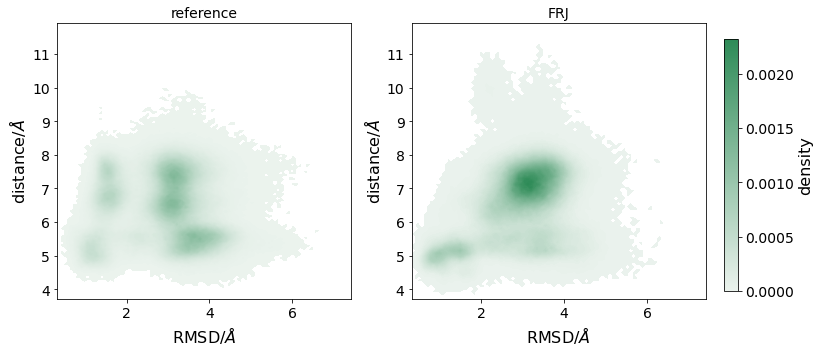

In [6]:
fig, ax, cbar = collection.plot_data((1,2))

## Clustering

The loaded data needs to be clustered to further discretize the conformational space. The same cluster centers will be used for all MSMs, and so all MSM data is pooled together for clustering. If `titles=` is specified in `MSMCollection.cluster()`, only those MSMs will be used for clustering. `n_clusters=` and `max_iter=` can be changed to different number of centers and *k-means* clustering iterations respectively.

In [7]:
collection.cluster()

27-11-23 12:01:50 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


Plot the clusters over data. Note that the cluster center are given as a list of center coordinates. This allows to plot multiple sets of centers, e.g. different metastable states.

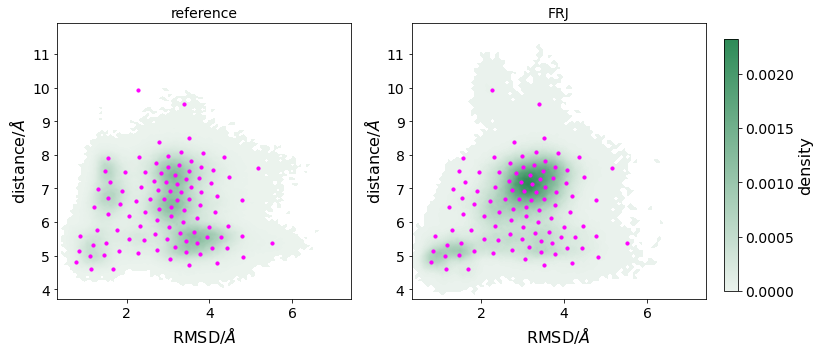

In [8]:
fig, ax, cbar = collection.plot_clusters([collection.clusters.clustercenters], (1,2))

The data for each MSM is then assigned to those cluster centers.

In [9]:
collection.assign_to_clusters()

## Implied timescales

Compute implied timescales to check for state separation and an appropriate lag time. If `titles=` specified, only those MSMs will have ITS computed.

Computing ITS...
reference
FRJ
...done.


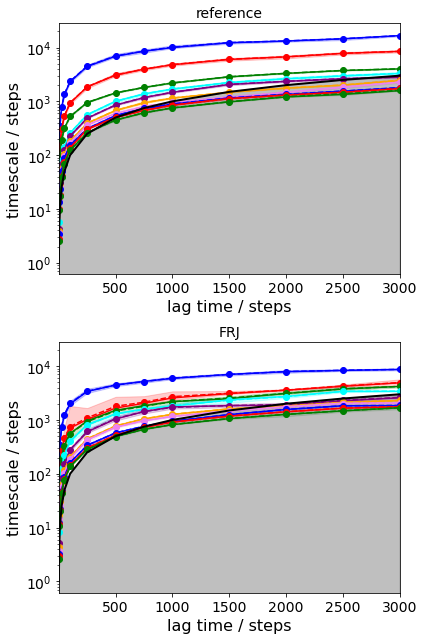

In [10]:
fig, ax = collection.compute_its()

## Build MSMs

Build the Markov State Models. Here a 20 ns lag time will be used.

In [11]:
collection.build_msms('20 ns')

Building MSMs...
...done.



The `pyemma.BayesianMSM` object is made accessible for any additional analysis:

In [12]:
collection['reference'].msm

BayesianMSM(conf=0.95, connectivity='largest', core_set=None,
      count_mode='effective', dt_traj='1 step', lag=2000,
      milestoning_method='last_core', mincount_connectivity='1/n',
      nsamples=100, nsteps=10, reversible=True, show_progress=False,
      sparse=False, statdist_constraint=None)

When MSMs are built using `pyemma`, the stationary distributions are computed for all connected sets:

In [13]:
collection['reference'].msm.stationary_distribution

array([0.01760912, 0.0047709 , 0.00995813, ..., 0.01463036, 0.0040223 ,
       0.02107173])

However, when using data pooled together, some clusters may not be visited by some of the systems used for MSMs. `pyemma` discards those clusters and rearranged stationary distribution, as well as the cluster indices in `connected_sets`. Therefore the `MSM` object has its own `stationary_distribution` where the discarded clusters are inserted back as having probability of 0.

In [14]:
collection['reference'].stationary_distribution

array([0.01760912, 0.0047709 , 0.00995813, ..., 0.01463036, 0.0040223 ,
       0.02107173])

## PCCA

In order to compare ligand effects on protein conformation distribution in a more meaningful way, the clusters are further assigned into metastable states using Perron Cluster-Cluster Analysis. Then the stationary probabilities for each metastable state are summed to give the probability of the system being in that state. `disconnected=` indicates which state the disconnected clusters are assigned to (since `pyemma` will not consider them during PCCA). If it is left as `None`, each cluster is assigned to the closest metastable state.

In [15]:
collection.pcca_assignments(2, 'reference', disconnected=0)

Metastable state assignments based on reference MSM, 2 states:
reference
MS 1 has 23 counts and 21.32% probability (± 0.47%)
MS 2 has 77 counts and 78.68% probability (± 0.58%)
--------------------
FRJ
MS 1 has 23 counts and 4.65% probability (± 0.18%)
MS 2 has 77 counts and 95.35% probability (± 0.9%)
--------------------



Visualize the state assignments:

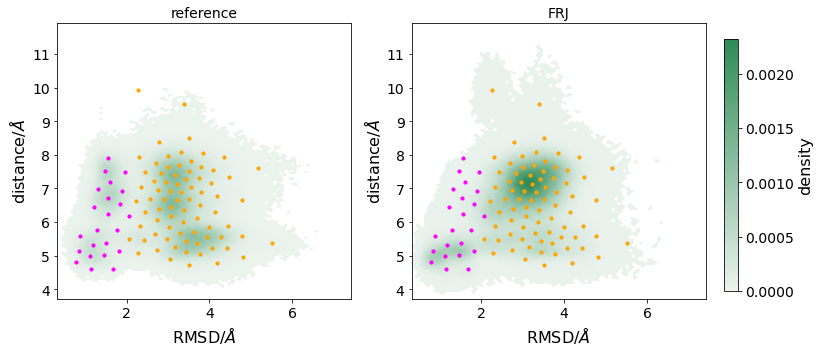

In [16]:
fig, ax, cbar = collection.plot_clusters(collection.get_pcca_clusters(2, ['reference'])[0], (1,2))

The assignment values are available with the information of which PCCA was used for the metastable states. The numbers given are state probability, standard deviation and cluster count.

In [17]:
collection['reference'].metastable_assignments

{'reference, 2 states': {1: [21.32, 0.47, 23], 2: [78.68, 0.58, 77]}}

## Bootstrapping

One way to evaluate whether the trajectory data making up the MSM has sufficient sampling is to perform bootstrapping by resampling. A random n out of n trajectories are resampled out of available data (i.e. some will be sampled more than once) and the state probability is computed. Bootstrapping uses the same clusters and macrostate assignments (set by `n_states=` and `msm=` arguments) throughout, only the input data is different. This results in a distribution of probability values for each state.

Bootstrapping is performed until either `max_iter=` is reached, or until the resulting state probability distribution is converged to a Gaussian distribution. Convergence is defined as the last `last=` iterations not changing the distribution mean within a `tol=` tolerance. If the same number of iterations is more suitable, rather than checking for convergence, `min_iter=` can be set to be the same as `max_iter=`.

The below bootstrapping will use the metastable assignment from 2 state PCCA performed on the reference MSM to carry out bootstrapping on both MSMs in the collection, until the last 10 iterations have not changed the mean within 1%

In [18]:
bootstrapped_probabilities = collection.bootstrapping(n_states=2, msm='reference', verbose=True, min_iter=10)

Bootstrapped probabilities, based on reference MSM, 2 states:
reference
State 1: 20.87% ± 5.38% (26 iterations)
State 2: 79.13% ± 5.38% (26 iterations)
------------------------------
FRJ
State 1: 4.81% ± 1.83% (45 iterations)
State 2: 95.19% ± 1.83% (45 iterations)
------------------------------


The resulting probability distributions can be plotted as violin plots. Looking at the plot of the metastable states above, the active state is state 1 (low RMSD to active state and low substrate-protein distance). State 2 is therefore the inactive state. `plot_bootstrapping_violin` requires the metastable state assignment, which are named based on msm the PCCA was based on and the number of states. It can also be seen in `MSM.metastable_assignments`.

In [19]:
collection.add_state_labels(2, ['active', 'inactive'])

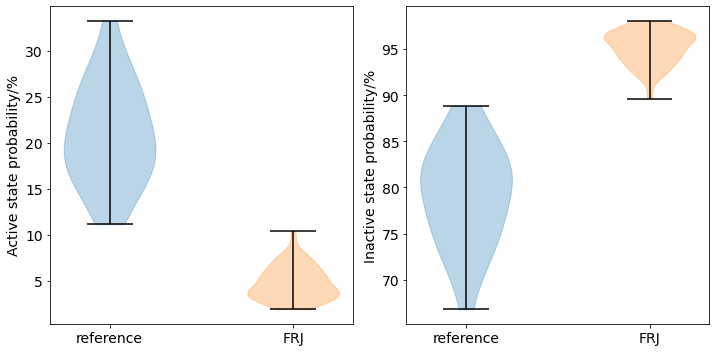

In [20]:
fig, ax = collection.plot_bootstrapping_violin('reference, 2 states')

The values are available as `metastable_assignments_bootstrapped`, as well as `bootstrapping_data` for any other analysis or plotting. `metastable_assignments_bootstrapped` gives the median, standard deviation and number of bootstrapping iterations for each state, while `bootstrapping_data` gives all of the probabilities and the trajectories that were used in each iteration.

In [21]:
collection['reference'].metastable_assignments_bootstrapped

{'reference, 2 states': {1: [20.87, 5.38, 26], 2: [79.13, 5.38, 26]}}

In [22]:
collection['reference'].bootstrapping_data

{'reference, 2 states': {'probabilities': array([[21.11, 78.89],
         [18.42, 81.58],
         [14.29, 85.71],
         ...,
         [24.86, 75.14],
         [18.89, 81.11],
         [19.48, 80.52]]),
  'trajectories': [array([ 92, 120,  16, ..., 155,  10, 131]),
   array([126, 183,  88, ...,   3, 161,  53]),
   array([101,  61,  62, ..., 170,  17,  16]),
   array([ 86, 168, 134, ..., 132, 186,   5]),
   array([161,  60,  54, ..., 106, 128, 175]),
   array([129, 130,   3, ..., 187, 183, 117]),
   array([158,  14, 177, ...,  88, 180, 181]),
   array([ 76,  61, 121, ..., 108, 196,  50]),
   array([122,  23,  28, ...,  14,  68,  98]),
   array([ 46, 130, 105, ..., 120, 170, 158]),
   array([163, 115, 106, ..., 153,  96, 145]),
   array([ 38,  63, 102, ..., 122, 160, 117]),
   array([ 57, 123,  48, ..., 169, 100,  44]),
   array([197,  64,  74, ...,  10,  51,  90]),
   array([ 87, 114, 199, ..., 167,  18, 120]),
   array([143, 196, 147, ...,  14, 186,   9]),
   array([185,  47, 188, .

## Saving the MSMs

The above can take a while, particularly the bootstrapping. The MSM collection can be saved and reloaded as follows:

In [23]:
collection.save('msm.pkl')

In [24]:
loaded_collection = MSMCollection('msm.pkl')

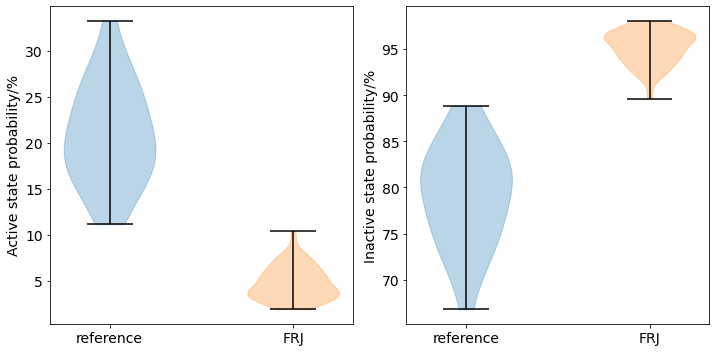

In [25]:
fig, ax = loaded_collection.plot_bootstrapping_violin('reference, 2 states')